# LANL Earthquakes Experiment
# Spectrogram Analysis

https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89

https://github.com/sevenfx/fastai_audio


TODO - external:
- go on to transformers.

TODO - spectrogram:
- generate as good-looking images as I can. may use [[1]](https://www.kaggle.com/michael422/spectrogram-convolution).
- normalize (in fastai or before it: just normalize the whole images together to mean 0 & sd 1; can try inside fastai and verify the mean was changed correctly; also understand what's imagenet_stats in fastai).
- V duplicate data using overlap between segments (10/25/50K jump instead of 150K).

TODO - NN:
- V use CV that respects buckets of segments. have a look at train_one() in zahar's code.

- understand how to use interpreter to diagnose NN actions - actually look at images with stressed zones, but good images rather than "top losses" ones.
- regression - show errors efficiently: 1. fix error in interpreter [(maybe use this)](https://forums.fast.ai/t/cnn-regression/28968); 2. distribution of errors; 3. boxplot(true value, predicted value).
   - look for regression that returns distribution rather than point estimator?

- optional: avoid pre-train and make sure converging from scratch? (https://towardsdatascience.com/hand-keypoints-detection-ec2dca27973e)
- try regularizations ([mixup](https://docs.fast.ai/callbacks.mixup.html), dropouts? (read; should be standard)).

- if looks good - go on to resnet50.
- add external (non-raw-signal) features.
   - find a way to extract the output of 1 or 2 layers before the final output (instead of the final output itself).
   - pass to Zahar a way to generate this "pre-output" as features for his model.
   - if possible - also pass to Zahar a way to train a network to generate these features (to allow features training with the same CV).
   - an alternative to 2 sequential models would be a single model with additional input in advanced layers - read about custom itemlist in fastai.


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import re
from pathlib import Path
import pickle as pkl
from time import time
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint
import os, sys
from warnings import warn
import itertools
import librosa
import librosa.display
from fastai.vision import *
from fastai.metrics import error_rate, mean_absolute_error

## Load and show data

In [3]:
n = int(150e3)
df = pd.read_csv('Data/train.csv', nrows=n, skiprows=None,
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)

df2 = pd.read_csv('Data/train.csv', nrows=n, skiprows=range(1,int(2.2e6)),
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df2.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)

df_peak = pd.read_csv('Data/train.csv', nrows=n, skiprows=range(1,int(4.4e6)),
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df_peak.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)

In [4]:
print(df.head())
print(df.info())
print(df.describe())

   signal  quaketime
0      12     1.4691
1       6     1.4691
2       8     1.4691
3       5     1.4691
4       8     1.4691
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 2 columns):
signal       150000 non-null int16
quaketime    150000 non-null float64
dtypes: float64(1), int16(1)
memory usage: 1.4 MB
None
              signal      quaketime
count  150000.000000  150000.000000
mean        4.884113       1.450182
std         5.101106       0.011248
min       -98.000000       1.430797
25%         3.000000       1.440398
50%         5.000000       1.449999
75%         7.000000       1.459599
max       104.000000       1.469100


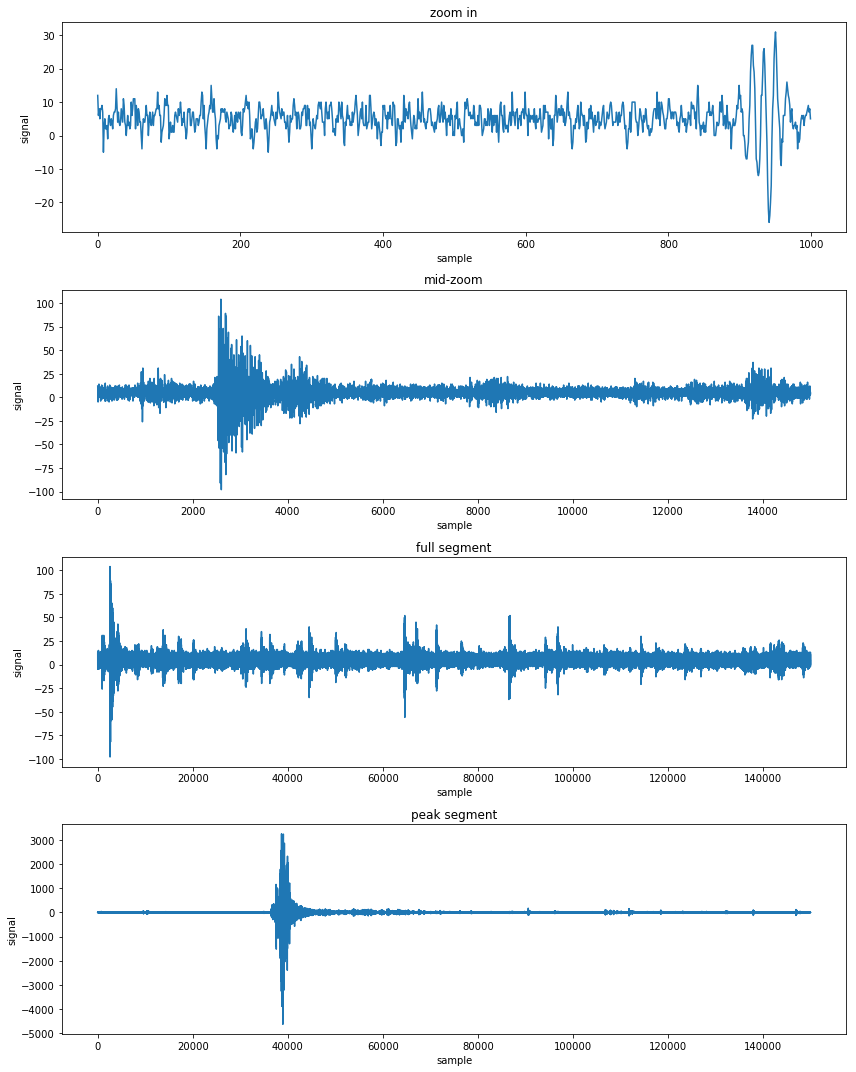

In [5]:
fig,axs = plt.subplots(4,1, figsize=(12,15))
axs[0].plot(df.signal.head(1000))
axs[1].plot(df.signal.head(15000))
axs[2].plot(df.signal.head(150000))
axs[3].plot(df_peak.signal)
for i,ax in enumerate(axs):
    ax.set_title(('zoom in','mid-zoom','full segment','peak segment')[i])
    ax.set_xlabel('sample')
    ax.set_ylabel('signal')
plt.tight_layout()

## Basic FFT
Note: there're suspected discontinuities in sampling times every 4096 samples ("batches"), so we find these discontinuities and compare batches FFTs with & without alignment to the discontinuity. Looks like the discontinuity does not noticably ruin the FFT, at least in the first 150K-samples segment.

In [6]:
def get_batches(df, verbose=True):
    dt = np.median(np.diff(-df.quaketime))
    transitions = np.where(np.logical_or(
        np.diff(-df.quaketime)>10*dt, np.diff(-df.quaketime)<-10*dt) )[0] + 1
    transitions = np.concatenate(([0], transitions, [len(df)]))
    if verbose:
        print('Distribution of blocks lengths:')
        l = [tf-ti for ti,tf in zip(transitions[:-1],transitions[1:])]
        print(tuple((g[0], len(list(g[1]))) for g in itertools.groupby(sorted(l))))
        print(f'Valid blocks (4096 samples):\t' +
              f'{np.sum(np.diff(transitions)==4096):.0f}/{len(l):d}')
    return transitions

transitions = get_batches(df)
transitions = get_batches(df_peak)

Distribution of blocks lengths:
((2545, 1), (4095, 1), (4096, 35))
Valid blocks (4096 samples):	35/37
Distribution of blocks lengths:
((3200, 1), (3440, 1), (4096, 35))
Valid blocks (4096 samples):	35/37


#### Standard segment

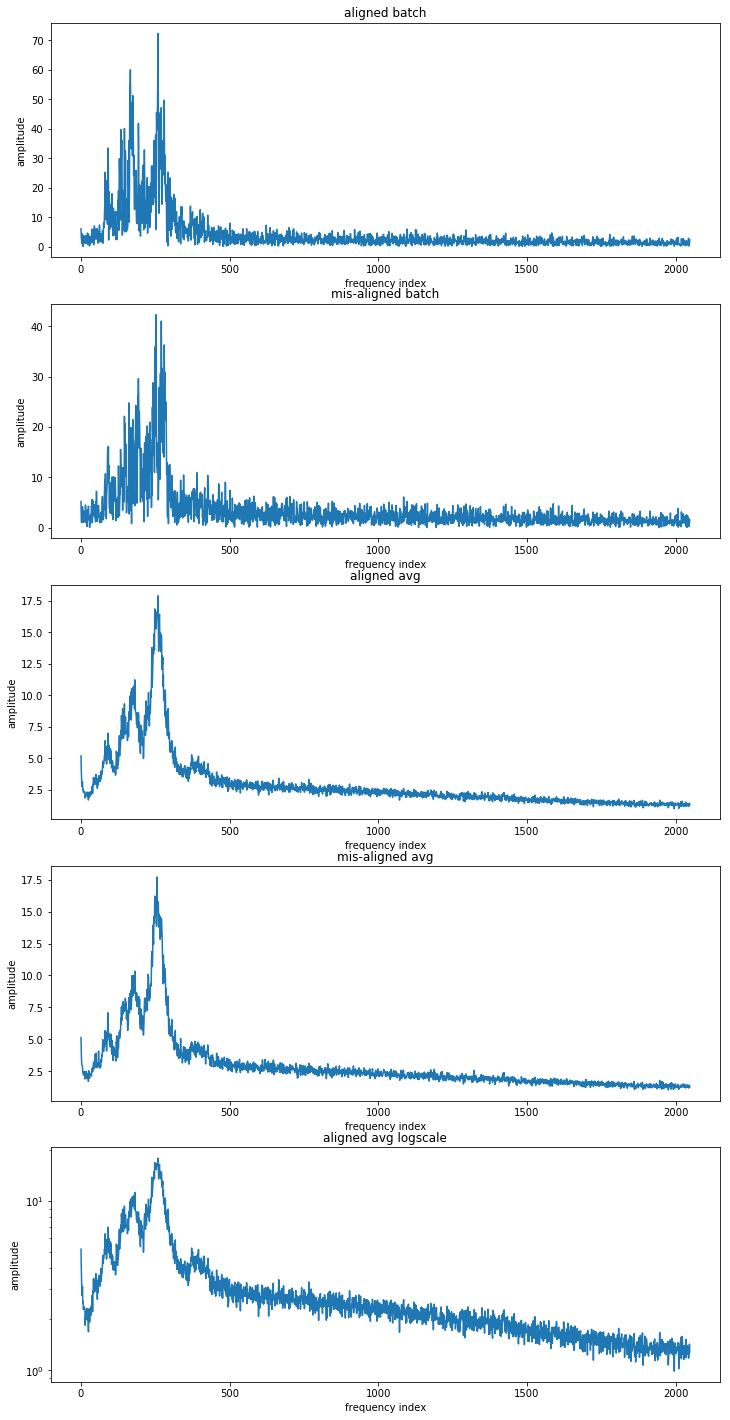

In [7]:
def batches_fft(df, transitions, offset=0):
    ffts = []
    for ti,tf in zip(transitions[:-1]+offset,transitions[1:]+offset):
        if tf-ti != 4096 or tf>=len(df): continue
        f = np.fft.rfft(df.signal[ti:tf], norm='ortho')[1:]
        ffts.append(np.abs(f))
    avg_fft = np.mean(ffts, axis=0)
    return (avg_fft, ffts)

ffts_aligned = batches_fft(df, transitions)
ffts_misaligned = batches_fft(df, transitions, 1000)

fig,axs = plt.subplots(5,1, figsize=(12,25))
axs[0].plot(ffts_aligned[1][0])
axs[1].plot(ffts_misaligned[1][0])
axs[2].plot(ffts_aligned[0])
axs[3].plot(ffts_misaligned[0])
axs[4].plot(ffts_aligned[0])
axs[4].set_yscale('log')
titles = ('aligned batch','mis-aligned batch','aligned avg','mis-aligned avg','aligned avg logscale')
for i,ax in enumerate(axs):
    ax.set_title(titles[i])
    ax.set_xlabel('frequency index')
    ax.set_ylabel('amplitude')

#### Peak segment

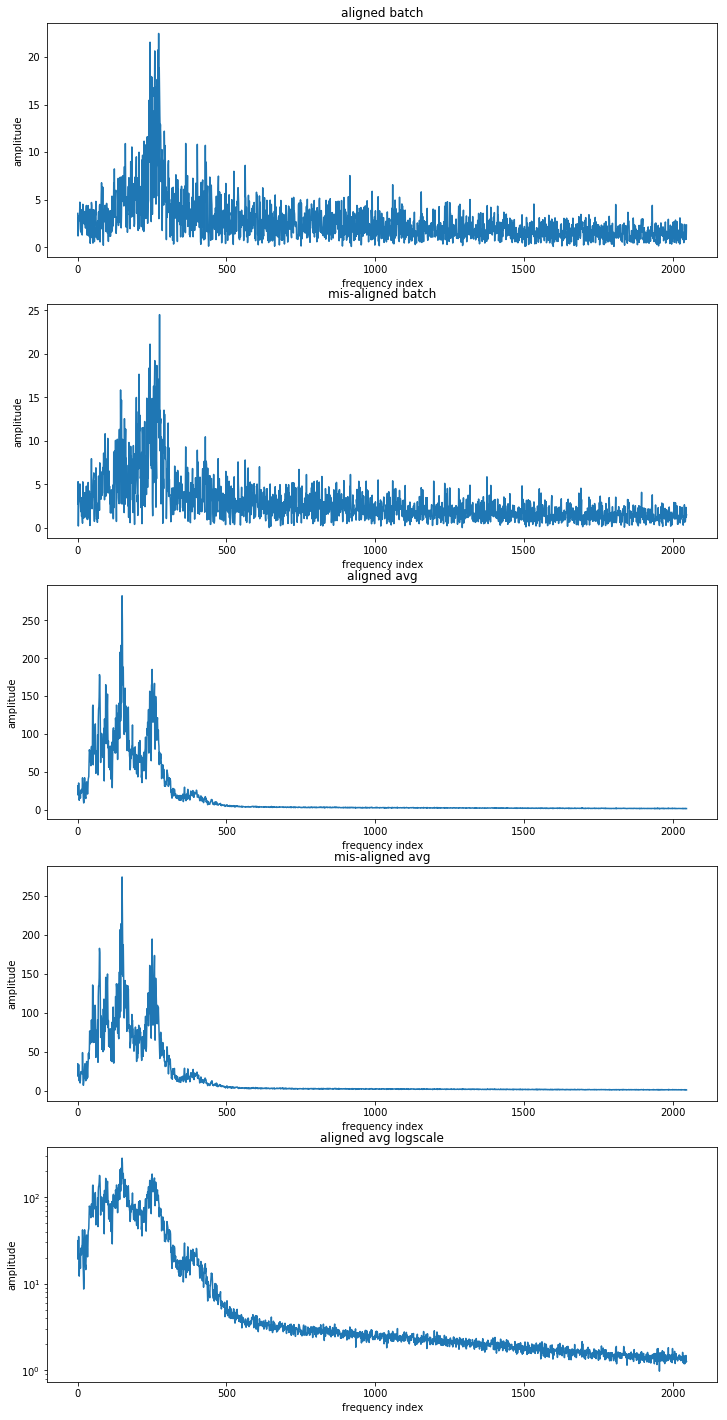

In [8]:
ffts_aligned = batches_fft(df_peak, transitions)
ffts_misaligned = batches_fft(df_peak, transitions, 1000)

fig,axs = plt.subplots(5,1, figsize=(12,25))
axs[0].plot(ffts_aligned[1][0])
axs[1].plot(ffts_misaligned[1][0])
axs[2].plot(ffts_aligned[0])
axs[3].plot(ffts_misaligned[0])
axs[4].plot(ffts_aligned[0])
axs[4].set_yscale('log')
titles = ('aligned batch','mis-aligned batch','aligned avg','mis-aligned avg','aligned avg logscale')
for i,ax in enumerate(axs):
    ax.set_title(titles[i])
    ax.set_xlabel('frequency index')
    ax.set_ylabel('amplitude')

## Spectrogram

Check linear vs. log frequency & linear vs. log power, in both "standard" and "peak" segments.

log power and log frequency look like the best images.

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\librosa\filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


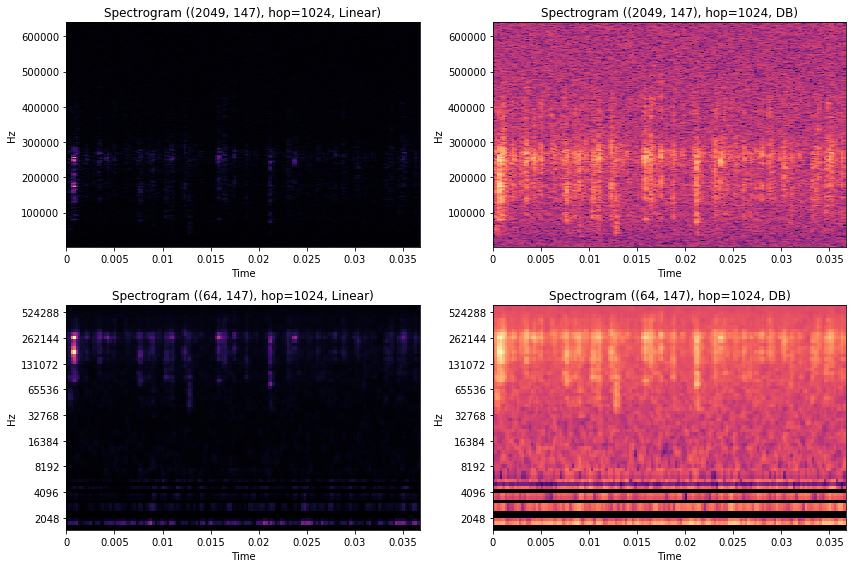

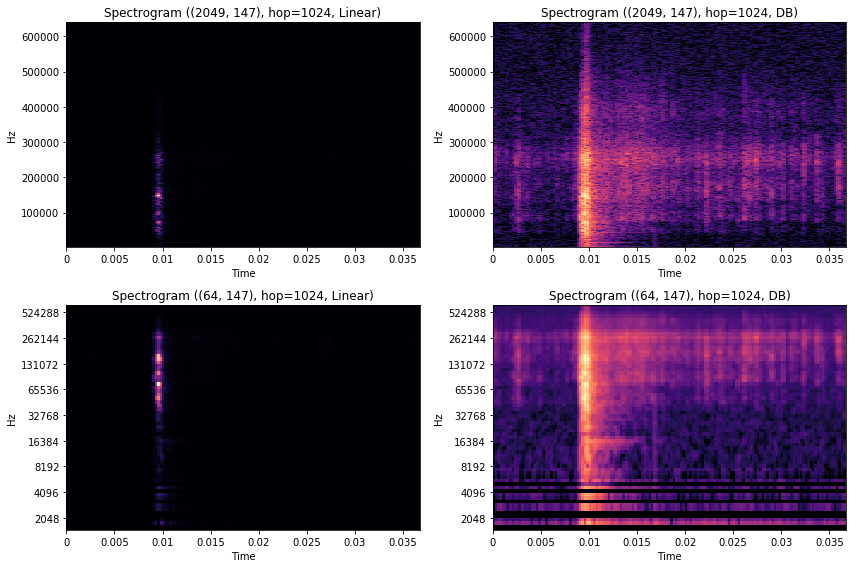

In [9]:
# Note - alternative plot code: plt.specgram(np.array(df.signal,dtype='float'), NFFT=4096, noverlap=2048, Fs=4096e3)
def plot_spec(df, n_fft=4096, hop_length=1024, sr=4096e3, n_mels=64, fmin=1480, fmax=640e3):
    stft = librosa.stft(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length)
    stft_magnitude, stft_phase = librosa.magphase(stft)
    stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)

    fig,axs = plt.subplots(2,2, figsize=(12,8))
    librosa.display.specshow(stft_magnitude, ax=axs[0,0], x_axis='time', y_axis='linear', 
                             sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
    axs[0,0].set_ylim((fmin,fmax))
    axs[0,0].set_title(f'Spectrogram ({stft_magnitude_db.shape}, hop={hop_length:d}, Linear)')

    librosa.display.specshow(stft_magnitude_db, ax=axs[0,1], x_axis='time', y_axis='linear', 
                             sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
    axs[0,1].set_ylim((fmin,fmax))
    axs[0,1].set_title(f'Spectrogram ({stft_magnitude_db.shape}, hop={hop_length:d}, DB)')

    mel_spec = librosa.feature.melspectrogram(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                              n_mels=n_mels, sr=sr, power=1.0,
                                              fmin=fmin, fmax=fmax)
    librosa.display.specshow(mel_spec, ax=axs[1,0], x_axis='time', y_axis='mel', 
                             sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
    axs[1,0].set_title(f'Spectrogram ({mel_spec.shape}, hop={hop_length:d}, Linear)')

    mel_spec = librosa.feature.melspectrogram(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                              n_mels=n_mels, sr=sr, power=1.0,
                                              fmin=fmin, fmax=fmax)
    mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
    librosa.display.specshow(mel_spec, ax=axs[1,1], x_axis='time', y_axis='mel', 
                             sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
    axs[1,1].set_title(f'Spectrogram ({mel_spec.shape}, hop={hop_length:d}, DB)')
    
    plt.tight_layout()

plot_spec(df)
plot_spec(df_peak)

Mels are logarithmically-wide frequency bands with universally-conventional values. They are used to convert audio signal to logarithmic frequency-scale. In the earthquakes non-conventional audio signal, the mel scale corrupts the spectrogram and creates the black lines that can be seen above.
Thus, we probably need to either change the whole Mel scale (which doesn't seem to be supported in librosa library) or use fictive sample rate.

A sample rate of 44KHz (instead of 400MHz) was chosen along with the rest of the spectrogram parameters as can be seen below. They all were chosen by trying several values and visually judging the resulted image.

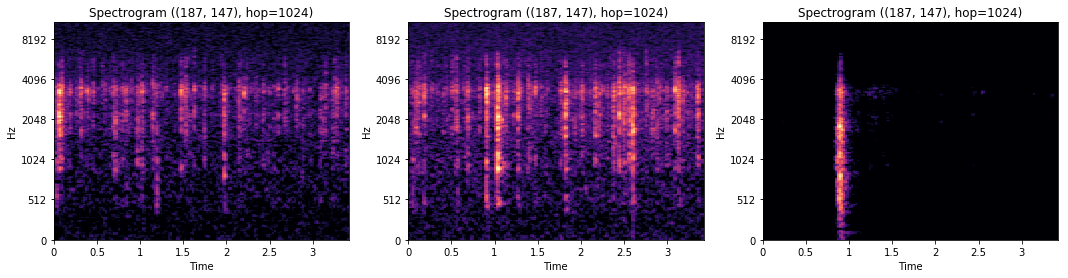

In [10]:
def plot_spec(dfs, n_fft=4096, hop_length=None, sr=44e3, n_mels=256, fmin=0, fmax=128e3, power=2.0, lin=False):
    if hop_length is None:
        hop_length = n_fft // 4
    fig,axs = plt.subplots(1+lin,len(dfs), figsize=(6*len(dfs),4+4*lin))
    for i,df in enumerate(dfs):
        ax = axs[0,i] if lin else axs[i]
        mel_spec = librosa.feature.melspectrogram(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                                  n_mels=n_mels, sr=sr, power=power)#, fmin=fmin, fmax=fmax)
        mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
        l = mel_spec.shape[0]
        mel_spec = mel_spec[int(0.02*l):int(0.75*l),:]
        librosa.display.specshow(mel_spec, ax=ax, x_axis='time', y_axis='mel', 
                                 sr=sr, hop_length=hop_length)#, fmin=fmin, fmax=fmax)
        ax.set_title(f'Spectrogram ({mel_spec.shape}, hop={hop_length:d})')
        
        if lin:
            ax = axs[1,i]
            stft = librosa.stft(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length)
            stft_magnitude, stft_phase = librosa.magphase(stft)
            stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)
            librosa.display.specshow(stft_magnitude_db, ax=ax, x_axis='time', y_axis='linear', 
                                     sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
            ax.set_ylim((fmin,fmax))
            ax.set_title(f'Spectrogram ({stft_magnitude_db.shape}, hop={hop_length:d})')


plot_spec((df,df2,df_peak), sr=44e3, n_fft=4096, n_mels=256, power=2.0)

## Generate spectrograms data

In [11]:
BASE = Path('Data')
TRAIN = BASE/'train_spec2'
SIZE = (187,147)

Read train data in 4 chunks of 1K segments;
save each segment's spectrogram (as png file);
and keep a table of segments and their quaketimes:

In [14]:
n_all = 629145480 # df_full.shape[0] # 629145480
seg_len = int(150e3)
hop_len = int(25e3) # try even 10e3?
n_hops = int(n_all/hop_len)
segs_to_read = 1050
hops_to_read = int(segs_to_read * seg_len/hop_len)

meta = pd.DataFrame(columns=('filename','time','class','mean','var'))

def save_spec(df, seg_index, meta, class_limits=(0,1,2,3,4,5,6,7,8,10,12,99), base_path=TRAIN,
              n_fft=4096, hop_length=1024, sr=44e3, n_mels=256, power=2.0):#, fmin=1480, fmax=640e3):
    tf = df.quaketime.values[-1]
    cls = np.where([a<=tf<b for a,b in zip(class_limits[:-1],class_limits[1:])])[0][0]
    cls_nm = '-'.join((f'{class_limits[cls]:02d}',f'{class_limits[cls+1]:02d}'))
    fname = str(seg_index) + '_' + cls_nm + '.png'
    
    mel_spec = librosa.feature.melspectrogram(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                              n_mels=n_mels, sr=sr, power=power)#, fmin=fmin, fmax=fmax)
    mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
    l = mel_spec.shape[0]
    mel_spec = mel_spec[int(0.02*l):int(0.75*l),:]
    meta.loc[i] = [fname, tf, cls_nm, np.mean(mel_spec), np.var(mel_spec)]
    plt.imsave(base_path/fname, mel_spec)


for i in tqdm_notebook(range(n_hops)):
    if i % hops_to_read == 0:
        tmp = pd.read_csv(BASE/'train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32},
                          nrows=seg_len*segs_to_read, skiprows=range(1,1+i*hop_len))
        tmp.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)
    save_spec(tmp[(i%segs_to_read)*hop_len:(i%segs_to_read)*hop_len+seg_len], i, meta)

meta.to_csv(TRAIN/'train_spec_meta.csv', index=False)
meta.head()

,filename,time,class,mean,var
0,0_01-02.png,1.430797,01-02,-67.566138,115.707084
1,1_01-02.png,1.424497,01-02,-69.796614,111.165175
2,2_01-02.png,1.418096,01-02,-68.377910,121.294547
3,3_01-02.png,1.411696,01-02,-70.582799,116.247891
4,4_01-02.png,1.404200,01-02,-69.218966,120.713055


In [15]:
np.random.seed(0)

## Cross Validation

Currently just use a single validation set rather than cross validation.
The validation set consists of 20% of the segments, in batches of 40 sequential segments (after x6 augmentation).

TODO: actual cross validation. see train_one() of Zahar.

In [16]:
valid_rate = 0.2
batch_size = 40
n_batches = n_hops // batch_size
n_val_batches = int(valid_rate * n_batches)
validation_batches = np.random.choice(range(n_batches), n_val_batches, replace=False)
val_ids = np.concatenate([np.arange(i0*batch_size,(i0+1)*batch_size,dtype=int) for i0 in validation_batches])
train_mean = np.mean([m for i,m in enumerate(meta['mean']) if i not in val_ids])
train_std = np.sqrt(np.mean([m for i,m in enumerate(meta['var']) if i not in val_ids])) # not really std...
pkl.dump((val_ids,train_mean,train_std), open(TRAIN/'validation_set.pkl','wb'))
(val_ids[:5], train_mean, train_std)

(array([8400, 8401, 8402, 8403, 8404]), -65.34439456068581, 11.920757756072435)

## Classification

In [30]:
meta = pd.read_csv(TRAIN/'train_spec_meta.csv')
val_ids, train_mean, train_std = pkl.load(open(TRAIN/'validation_set.pkl','rb'))
val_ids = np.array([1,2,3])
val_set = set(meta.iloc[val_ids]['filename'])

In [44]:
#data = ImageDataBunch.from_df('Data/train_spec/tmp',
#                               meta2[['i','class']].iloc[[0,6,29,325]], size=(128,293), bs=4)#.normalize(imagenet_stats)
#data = ImageDataBunch.from_df(TRAIN,  meta[['filename','class']], ds_tfms=[], size=SIZE, bs=32, val_idxs=val_ids).normalize()
# TODO I really hope the normalization is what I mean; either verify or understand what to do.
data = ImageDataBunch.create_from_ll(
    (ImageList.from_df(meta[['filename','class']], path=TRAIN, folder=None, suffix='', cols=0)
                .split_by_valid_func(lambda nm: os.path.basename(nm) in val_set) # .split_by_rand_pct(seed=0)
                .label_from_df(label_delim=None, cols=1)),
    ds_tfms=[], size=SIZE, bs=32
).normalize()
data

ImageDataBunch;

Train: LabelList (97 items)
x: ImageList
Image (3, 187, 147),Image (3, 187, 147),Image (3, 187, 147),Image (3, 187, 147),Image (3, 187, 147)
y: CategoryList
01-02,01-02,01-02,01-02,01-02
Path: Data\train_spec2;

Valid: LabelList (3 items)
x: ImageList
Image (3, 187, 147),Image (3, 187, 147),Image (3, 187, 147)
y: CategoryList
01-02,01-02,01-02
Path: Data\train_spec2;

Test: None

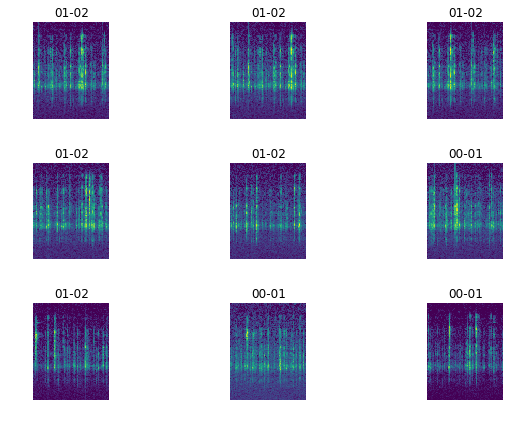

In [45]:
data.show_batch(rows=3, figsize=(9,6))

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(4)

In [ ]:
learn.save('model_spec_class_resnet34_freezed')

In [ ]:
learn.load('model_spec_class_resnet34_freezed')

interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(5e-6,5e-3))

In [ ]:
learn.save('model_spec_class_resnet34_unfreezed')

interp2 = ClassificationInterpretation.from_learner(learn)
interp2.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
def confusion2mae(M, class_limits=np.array([0,1,2,3,4,5,6,7,8,10,12,14])):
    class_centers = (class_limits[1:]+class_limits[:-1])/2
    class_lengths = np.diff(class_limits)
    tot_err = 0
    n = 0
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            n += M[i,j]
            tot_err += M[i,j] * (np.abs(class_centers[i]-class_centers[j]) if i!=j else class_lengths[i]/3)
    return tot_err / n

confusion2mae(interp2.confusion_matrix())

## Regression

Note: range of MAE should be between 2.0 (excellent) and 2.2 (quite bad), for CV that takes groups of 20 x3-augmented-segments (i.e. 7 original segments, or 1.05M samples) as homogeneous buckets.

In [ ]:
meta = pd.read_csv(TRAIN/'train_spec_meta.csv')
#data_class = data
#data = ImageDataBunch.from_df(TRAIN,  meta[['filename','time']], size=(128,293), bs=32)
data = (PointsItemList.from_df(meta[['filename','time']], TRAIN)
        .split_by_valid_func(lambda nm: os.path.basename(nm) in val_set) # .split_by_rand_pct(seed=0)
        .label_from_df(cols='time', label_cls=FloatList)
        .transform(size=SIZE)
        .databunch())
data.batch_size = 32
data

In [ ]:
class L1LossFlat(nn.L1Loss):
    '''Mean Absolute Error Loss'''
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))

learn = cnn_learner(data, models.resnet34, loss_func=mean_absolute_error, metrics=mean_absolute_error)
learn.loss = L1LossFlat

In [ ]:
learn.fit_one_cycle(4)

In [ ]:
learn.save('model_spec_reg_resnet34_freezed')

In [ ]:
learn.save('model_spec_reg_resnet34_freezed')
# TODO debug
#interp3 = ClassificationInterpretation.from_learner(learn)
#losses,idxs = interp3.top_losses()